<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [23]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

from scipy.stats import bernoulli, beta   

+ **UserID**: Numero único que identifica a cada jugador.
+ **Version**: Si el jugador se colocó en el grupo de control (puerta_30 - una puerta en el nivel 30) o en el grupo con la puerta movida (puerta_40 - una puerta en el nivel 40).
+ **sum_gamerounds**: El número de rondas de juego jugadas por el jugador durante los primeros 14 días después de la instalación.
+ **retention_1**: ¿Regresó el jugador y jugó 1 día después de la instalación?
+ **retention_7**: ¿Regresó el jugador y jugó 7 días después de la instalación?


In [6]:
# datos

df = pd.read_csv('data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [8]:
df.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [55]:
gate_30_r1 = len(df[(df['version'] == 'gate_30') & (df.retention_1 == True)])
gate_30_r1 

20034

In [56]:
gate_40_r1 = len(df[(df['version'] == 'gate_40') & (df.retention_1 == True)])
gate_40_r1

20119

In [49]:
# los datos son conocidos : impresiones y conversiones para test y control, el resultado es un porcentaje

gate_40  =  45489
gate_30  =  44700

imps_ctrl, convs_ctrl = gate_30, gate_30_r1    # impresiones de control y conversiones de control // entrar, comprar

imps_test, convs_test = gate_40, gate_40_r1

CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'


'Tasas conversion: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [50]:
# a prioris, es tu ignorancia, lo que desconoces 

a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [51]:
x=np.linspace(0.42, 0.48, 100)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

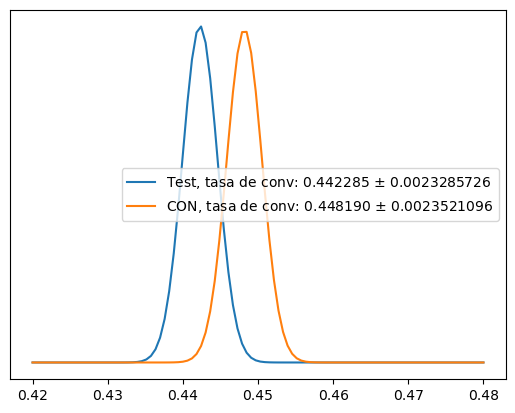

In [52]:
plot([beta_test, beta_control], ['Test', 'CON'])  #el test empeora los rsultados, la tasa de conversion  es menor 

In [53]:
'''el salto nos da la diferencia normalizada de las medias de test y de control, es el procentaje de reduccion o de aumento, en este caso es de reduccion,

el salto nos devuelve una probabilidad. 

Si la curva estaria por encima tendiramos que cambiar beta test por beta control '''

salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()

salto

0.013175098158249857

In [54]:
prob = beta_test.cdf(0.445)
prob

0.8781293616836601

In [ ]:
El salto me dice un aumento o une disminucion en base a una probabilidad. Bayesiana


In [2]:
# transformacion



In [3]:
# muestreo


In [4]:
# testeo para retention_1


In [5]:
# testeo para retention_7



In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.